# Base Libraries --> Import

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# pip install lightgbm 

In [3]:
# pip install shap 

In [4]:
#light bgm model
import lightgbm as lgb
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Import Data 

In [5]:
# import data 

import pandas as pd

train = pd.read_csv('train.csv',parse_dates=['date'])
test = pd.read_csv('test.csv',parse_dates=['date'])
df = pd.concat([train, test], sort=False)


print(train.shape, test.shape, df.shape)
df.head()



(913000, 4) (45000, 4) (958000, 5)


,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [6]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [7]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


# Data Analysis 

In [ ]:
#Data Analysis
train.store.nunique() 

In [ ]:
test.store.nunique(), train.item.nunique(), test.item.nunique()

In [ ]:
## there are 10 store 
## there are 50 items 

In [ ]:
# Time Range
train["date"].min(), train["date"].max(), test["date"].min(), test["date"].max()


In [ ]:
# train == 2013-01-01 to 2017-12-31
# test == 2018-01-01 to 2018-03-31

In [ ]:
# How many items are in the store?
df.groupby(["store"])["item"].nunique()

In [ ]:
# Summary Stats for each store
df.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

In [ ]:
# Summary Stats for each item
df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

In [ ]:
## Histogram : Store Sales

fig, axes = plt.subplots(2, 5,figsize=(20, 10)) ## in 2 rows and 5 columns 
for i in range(1,11):
    if i < 6:
        train[train.store == i].sales.hist(ax=axes[0, i-1])      ## graphical axes (0,0)==> center 
                                                                ## (0,1) ==> 1 co-ordinate right from center
        axes[0,i-1].set_title("Store " + str(i), fontsize = 15) ## subtitle  
        
    else:
        train[train.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
        
## plotting histogram for each store sales 

plt.tight_layout(pad=4.5)  ## distance between each histogram of each store 
plt.suptitle("Histogram: Sales"); ## main title 


        


In [ ]:
## optional 
store= input("Enter store id")
train[train.store == int(store)].sales.hist().set_title("Store " + str(store), fontsize = 15)

plt.show()


In [ ]:
## histogram for item(50) sales in each store *here store 1*

store = 1
sub = train[train.store == store].set_index("date")

fig, axes = plt.subplots(10, 5, figsize=(40, 55)) #10 row, 5 column 
for i in range(1,51): ##since 50 item 
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")  
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Sales Diagram");
plt.show()

In [ ]:
##optional 

store= input("Enter the store id")
item = input("Enter the item number")
#store = 2
#item = 30
sub = train[train.store == int(store)].set_index("date")
sub[sub.item == int(item)].sales.plot(legend=True, label = "Item "+str(item)+" Sales"+" of Store "+str(store)) 


plt.show()

# Feature Engineering

In [8]:

# Time-related feature == creating time related features

def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4   ### df.date.dt.weekday => Starts from '0' means '0' = 'Monday'. 
                                               ##So, '// 4' will give '1' when day number equals
                                            ## so does for 5 and 6 gives '1' for //4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    return df
df = create_date_features(train)

In [9]:
df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end
0,2013-01-01,1,1,13,1,1,1,1,2,2013,0,1,0,1,0
1,2013-01-02,1,1,11,1,2,2,1,3,2013,0,0,0,0,0
2,2013-01-03,1,1,14,1,3,3,1,4,2013,0,0,0,0,0
3,2013-01-04,1,1,13,1,4,4,1,5,2013,1,0,0,0,0
4,2013-01-05,1,1,10,1,5,5,1,6,2013,1,0,0,0,0


In [10]:

#Lag/Shifted Features
#==> 1. every feature should be sorted 
#==> 2. generate new features for each 'item' in each 'store' according to 'date' order

#to sort 
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

#lagging ==> how many sales 1 day before in column "lag1" and so on
"""but here new features are being generated using target variable= sales 
and since target variable is being used == data leakage is possible / overfitteing of data ==> machine loses generalization ability
so adding random noise"""



#lagging 
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe) # Adding random noise to each value.
    return dataframe

#random noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# passing variables and creating feature
lags_list = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728] 
df = lag_features(df, lags_list) 




In [11]:
df.tail()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
912995,2017-12-27,10,50,63,12,27,361,52,3,2017,0,0,0,0,0,83.181742,71.538526,84.740679,80.031481,77.832898,101.521038,91.529833,41.650460,80.751498,49.186882
912996,2017-12-28,10,50,59,12,28,362,52,4,2017,0,0,0,0,0,83.437283,89.370267,89.779718,79.140208,92.917168,85.764575,122.746028,69.972601,91.581761,44.320570
912997,2017-12-29,10,50,74,12,29,363,52,5,2017,1,0,0,0,0,90.063614,96.178230,93.117468,96.522147,96.118629,97.065389,110.356297,61.875315,98.323592,62.375426
912998,2017-12-30,10,50,62,12,30,364,52,6,2017,1,0,0,0,0,105.743758,96.314721,98.819293,90.942229,90.435487,95.340896,120.391164,65.807084,113.045500,66.706539
912999,2017-12-31,10,50,82,12,31,365,52,7,2017,1,0,1,0,1,98.476784,96.347481,107.175431,96.847542,102.303603,116.754111,119.643946,67.851218,124.433441,77.271073


In [12]:

## Rolling mean feature ==> takes "n" previous target variable and averages them and returns as a new value

"""For instance "roll2" takes previous 2 variable and averages it 
Again it uses target variables 
so adding noise on purpose """

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

roll_mean_list = [365, 546]
df = roll_mean_features(df, roll_mean_list)

In [13]:
df.tail()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
912995,2017-12-27,10,50,63,12,27,361,52,3,2017,0,0,0,0,0,83.181742,71.538526,84.740679,80.031481,77.832898,101.521038,91.529833,41.650460,80.751498,49.186882,85.969422,80.552312
912996,2017-12-28,10,50,59,12,28,362,52,4,2017,0,0,0,0,0,83.437283,89.370267,89.779718,79.140208,92.917168,85.764575,122.746028,69.972601,91.581761,44.320570,87.936973,83.478939
912997,2017-12-29,10,50,74,12,29,363,52,5,2017,1,0,0,0,0,90.063614,96.178230,93.117468,96.522147,96.118629,97.065389,110.356297,61.875315,98.323592,62.375426,92.743334,78.268175
912998,2017-12-30,10,50,62,12,30,364,52,6,2017,1,0,0,0,0,105.743758,96.314721,98.819293,90.942229,90.435487,95.340896,120.391164,65.807084,113.045500,66.706539,90.543958,83.551912
912999,2017-12-31,10,50,82,12,31,365,52,7,2017,1,0,1,0,1,98.476784,96.347481,107.175431,96.847542,102.303603,116.754111,119.643946,67.851218,124.433441,77.271073,91.868207,84.237797


In [14]:

#Exponentially Weighted Mean Features ==> parameter alpha [0,1]
                                         #alpha close to 1 == more weight to close days 
    
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

# In here we have two combinations : alphas and lags. 
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)



In [15]:
df.tail()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
912995,2017-12-27,10,50,63,12,27,361,52,3,2017,0,0,0,0,0,83.181742,71.538526,84.740679,80.031481,77.832898,101.521038,91.529833,41.650460,80.751498,49.186882,85.969422,80.552312,79.914487,72.548186,83.312732,79.052689,112.421502,99.398046,60.057616,80.309924,50.694458,79.775790,73.014965,82.661721,79.031032,112.682169,97.793775,60.130827,80.559776,50.386242,79.444094,73.830676,81.531275,78.880715,112.703381,94.582035,60.324250,81.003722,49.817414,79.206836,74.678766,80.725736,78.765870,112.055216,91.364220,60.573486,81.586176,49.410597,79.657373,77.143760,80.401219,79.356088,109.036310,84.929217,61.127792,84.107010,49.495322
912996,2017-12-28,10,50,59,12,28,362,52,4,2017,0,0,0,0,0,83.437283,89.370267,89.779718,79.140208,92.917168,85.764575,122.746028,69.972601,91.581761,44.320570,87.936973,83.478939,81.895724,88.177409,89.665637,78.052634,118.671075,109.469902,43.852881,90.465496,44.334723,81.777579,87.401497,89.266172,78.103103,118.368217,108.779377,44.713083,89.955978,44.638624,81.488819,85.966135,88.306255,78.176143,117.740676,106.916407,46.464850,89.000744,45.163483,81.162051,84.703630,87.217721,78.229761,116.916565,104.409266,48.272046,88.175853,45.623179,80.828687,83.071880,85.200610,78.678044,114.018155,97.464609,52.063896,87.553505,46.747661
912997,2017-12-29,10,50,74,12,29,363,52,5,2017,1,0,0,0,0,90.063614,96.178230,93.117468,96.522147,96.118629,97.065389,110.356297,61.875315,98.323592,62.375426,92.743334,78.268175,89.594786,96.558870,93.783282,96.052632,119.933554,66.273495,66.792644,100.473275,58.266736,89.177758,96.040150,93.526617,95.110310,119.836822,68.477938,65.671308,99.895598,57.563862,88.297764,94.793227,92.861251,93.235229,119.548135,72.583281,63.692970,98.600149,56.232697,87.348615,93.311089,91.965316,91.368928,119.074969,76.122780,62.081614,97.152756,54.986954,85.414343,90.035940,89.600305,87.839022,117.009078,80.732304,60.031948,94.276753,52.873830
912998,2017-12-30,10,50,62,12,30,364,52,6,2017,1,0,0,0,0,105.743758,96.314721,98.819293,90.942229,90.435487,95.340896,120.391164,65.807084,113.045500,66.706539,90.543958,83.551912,102.329739,96.977944,96.839164,93.152632,100.046678,104.013675,63.189632,112.373664,62.763337,101.617776,96.904015,96.652662,93.211031,101.083682,102.247794,63.267131,111.689560,62.456386,100.059553,96.558645,96.172250,93.047046,103.109627,99.316656,63.138594,110.120030,61.646539,98.304585,95.893327,95.489595,92.510678,105.022491,97.036834,62.724484,108.245827,60.596086,94.20

In [16]:
##Done few feature engineering now shape of data:
df.shape

(913000, 72)

In [17]:
#one-hot encoding ==> ensures that machine learning does not assume that higher numbers are more important

df = pd.get_dummies(df, columns=['store', 'item'])
df.head()

,date,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
0,2013-01-01,13,1,1,1,1,2,2013,0,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11,1,2,2,1,3,2013,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14,1,3,3,1,4,2013,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13,1,4,4,1,5,2013,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10,1,5,5,1,6,2013,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
#fill NAN values with mean
df['sales_lag_91'].fillna(int(df['sales_lag_91'].mean()), inplace=True)
df['sales_lag_98'].fillna(int(df['sales_lag_98'].mean()), inplace=True)
df['sales_lag_105'].fillna(int(df['sales_lag_105'].mean()), inplace=True)
df['sales_lag_112'].fillna(int(df['sales_lag_112'].mean()), inplace=True)
df['sales_lag_119'].fillna(int(df['sales_lag_119'].mean()), inplace=True)
df['sales_lag_126'].fillna(int(df['sales_lag_126'].mean()), inplace=True)
df['sales_lag_182'].fillna(int(df['sales_lag_182'].mean()), inplace=True)
df['sales_lag_364'].fillna(int(df['sales_lag_364'].mean()), inplace=True)
df['sales_lag_546'].fillna(int(df['sales_lag_546'].mean()), inplace=True)
df['sales_lag_728'].fillna(int(df['sales_lag_728'].mean()), inplace=True)

In [19]:
df['sales_roll_mean_365'].fillna(int(df['sales_roll_mean_365'].mean()),inplace=True)
df['sales_roll_mean_546'].fillna(int(df['sales_roll_mean_546'].mean()),inplace=True)

In [20]:
df['sales_ewm_alpha_095_lag_91'].fillna(int(df['sales_ewm_alpha_095_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_98'].fillna(int(df['sales_ewm_alpha_095_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_105'].fillna(int(df['sales_ewm_alpha_095_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_112'].fillna(int(df['sales_ewm_alpha_095_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_180'].fillna(int(df['sales_ewm_alpha_095_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_270'].fillna(int(df['sales_ewm_alpha_095_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_365'].fillna(int(df['sales_ewm_alpha_095_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_546'].fillna(int(df['sales_ewm_alpha_095_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_095_lag_728'].fillna(int(df['sales_ewm_alpha_095_lag_728'].mean()),inplace=True)

In [21]:
df['sales_ewm_alpha_09_lag_91'].fillna(int(df['sales_ewm_alpha_09_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_98'].fillna(int(df['sales_ewm_alpha_09_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_105'].fillna(int(df['sales_ewm_alpha_09_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_112'].fillna(int(df['sales_ewm_alpha_09_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_180'].fillna(int(df['sales_ewm_alpha_09_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_270'].fillna(int(df['sales_ewm_alpha_09_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_365'].fillna(int(df['sales_ewm_alpha_09_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_546'].fillna(int(df['sales_ewm_alpha_09_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_09_lag_728'].fillna(int(df['sales_ewm_alpha_09_lag_728'].mean()),inplace=True)

In [22]:
df['sales_ewm_alpha_08_lag_91'].fillna(int(df['sales_ewm_alpha_08_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_98'].fillna(int(df['sales_ewm_alpha_08_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_105'].fillna(int(df['sales_ewm_alpha_08_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_112'].fillna(int(df['sales_ewm_alpha_08_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_180'].fillna(int(df['sales_ewm_alpha_08_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_270'].fillna(int(df['sales_ewm_alpha_08_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_365'].fillna(int(df['sales_ewm_alpha_08_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_546'].fillna(int(df['sales_ewm_alpha_08_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_08_lag_728'].fillna(int(df['sales_ewm_alpha_08_lag_728'].mean()),inplace=True)

In [23]:
df['sales_ewm_alpha_07_lag_91'].fillna(int(df['sales_ewm_alpha_07_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_98'].fillna(int(df['sales_ewm_alpha_07_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_105'].fillna(int(df['sales_ewm_alpha_07_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_112'].fillna(int(df['sales_ewm_alpha_07_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_180'].fillna(int(df['sales_ewm_alpha_07_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_270'].fillna(int(df['sales_ewm_alpha_07_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_365'].fillna(int(df['sales_ewm_alpha_07_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_546'].fillna(int(df['sales_ewm_alpha_07_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_07_lag_728'].fillna(int(df['sales_ewm_alpha_07_lag_728'].mean()),inplace=True)

In [24]:
df['sales_ewm_alpha_05_lag_91'].fillna(int(df['sales_ewm_alpha_05_lag_91'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_98'].fillna(int(df['sales_ewm_alpha_05_lag_98'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_105'].fillna(int(df['sales_ewm_alpha_05_lag_105'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_112'].fillna(int(df['sales_ewm_alpha_05_lag_112'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_180'].fillna(int(df['sales_ewm_alpha_05_lag_180'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_270'].fillna(int(df['sales_ewm_alpha_05_lag_270'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_365'].fillna(int(df['sales_ewm_alpha_05_lag_365'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_546'].fillna(int(df['sales_ewm_alpha_05_lag_546'].mean()),inplace=True)
df['sales_ewm_alpha_05_lag_728'].fillna(int(df['sales_ewm_alpha_05_lag_728'].mean()),inplace=True)

In [25]:
#standardization
df['sales'] = np.log1p(df["sales"].values)

In [26]:
##SMAPE score

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

# Calculating SMAPE for LightGBM output:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [27]:
df.head()

,date,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
0,2013-01-01,2.639057,1,1,1,1,2,2013,0,1,0,1,0,52.0,52.0,52.0,52.0,51.0,51.0,51.0,50.0,49.0,48.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,51.0,51.0,50.0,50.0,49.0,48.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,2.484907,1,2,2,1,3,2013,0,0,0,0,0,52.0,52.0,52.0,52.0,51.0,51.0,51.0,50.0,49.0,48.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,51.0,51.0,50.0,50.0,49.0,48.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,2.708050,1,3,3,1,4,2013,0,0,0,0,0,52.0,52.0,52.0,52.0,51.0,51.0,51.0,50.0,49.0,48.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,51.0,51.0,50.0,50.0,49.0,48.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,2.639057,1,4,4,1,5,2013,1,0,0,0,0,52.0,52.0,52.0,52.0,51.0,51.0,51.0,50.0,49.0,48.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,51.0,51.0,50.0,50.0,49.0,48.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,2.397895,1,5,5,1,6,2013,1,0,0,0,0,52.0,52.0,52.0,52.0,51.0,51.0,51.0,50.0,49.0,48.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,48.0,52.0,52.0,52.0,52.0,51.0,50.0,50.0,49.0,4

# Split data

In [28]:
#  train and validation set.
train = df.loc[(df["date"] < "2017-01-01"), :] # Until beginning of 2017
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :] # First 3 months of 2017

#dropping useless column
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((730500,), (730500, 127), (45000,), (45000, 127))

# Lgbm model

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score ,mean_absolute_percentage_error

In [30]:
#lgbm in without any parameters 
first_model = lgb.LGBMRegressor().fit(X_train, Y_train)

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))
pred = first_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))

TRAIN SMAPE: 3.6747260901375722
VALID SMAPE: 3.916638457925667
MAE: 0.1296597407277123
RMSE: 0.02885865224408837
R2 Score: 0.9134620774518842


In [39]:
#Feature Importance 
"""calculate a score for all the input features for a given model
- the scores simply represent the “importance” of each feature"""


'calculate a score for all the input features for a given model\n- the scores simply represent the “importance” of each feature'

# Catboost Regressor

In [40]:
pip install catboost

In [41]:
from catboost import CatBoostRegressor
first_model = CatBoostRegressor()
first_model.fit(X_train, Y_train)

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))
pred = first_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))


Learning rate set to 0.116046
0:	learn: 0.5266885	total: 414ms	remaining: 6m 53s
1:	learn: 0.4823694	total: 674ms	remaining: 5m 36s
2:	learn: 0.4441594	total: 981ms	remaining: 5m 26s
3:	learn: 0.4109134	total: 1.26s	remaining: 5m 13s
4:	learn: 0.3799442	total: 1.55s	remaining: 5m 9s
5:	learn: 0.3541261	total: 1.81s	remaining: 5m
6:	learn: 0.3318486	total: 2.08s	remaining: 4m 55s
7:	learn: 0.3114459	total: 2.33s	remaining: 4m 48s
8:	learn: 0.2938834	total: 2.63s	remaining: 4m 49s
9:	learn: 0.2792539	total: 2.99s	remaining: 4m 56s
10:	learn: 0.2663632	total: 3.41s	remaining: 5m 6s
11:	learn: 0.2556626	total: 3.75s	remaining: 5m 8s
12:	learn: 0.2458350	total: 3.99s	remaining: 5m 2s
13:	learn: 0.2373359	total: 4.25s	remaining: 4m 59s
14:	learn: 0.2302329	total: 4.54s	remaining: 4m 58s
15:	learn: 0.2241140	total: 4.78s	remaining: 4m 54s
16:	learn: 0.2190009	total: 5.02s	remaining: 4m 50s
17:	learn: 0.2143542	total: 5.28s	remaining: 4m 47s
18:	learn: 0.2102888	total: 5.55s	remaining: 4m 46s


158:	learn: 0.1706580	total: 41.4s	remaining: 3m 38s
159:	learn: 0.1705938	total: 41.6s	remaining: 3m 38s
160:	learn: 0.1705220	total: 41.8s	remaining: 3m 37s
161:	learn: 0.1704839	total: 42.1s	remaining: 3m 37s
162:	learn: 0.1704548	total: 42.4s	remaining: 3m 37s
163:	learn: 0.1704360	total: 42.6s	remaining: 3m 37s
164:	learn: 0.1704194	total: 42.8s	remaining: 3m 36s
165:	learn: 0.1703898	total: 43.1s	remaining: 3m 36s
166:	learn: 0.1703700	total: 43.3s	remaining: 3m 35s
167:	learn: 0.1703063	total: 43.5s	remaining: 3m 35s
168:	learn: 0.1702472	total: 43.8s	remaining: 3m 35s
169:	learn: 0.1702069	total: 44.1s	remaining: 3m 35s
170:	learn: 0.1701568	total: 44.3s	remaining: 3m 34s
171:	learn: 0.1701312	total: 44.5s	remaining: 3m 34s
172:	learn: 0.1700687	total: 44.8s	remaining: 3m 33s
173:	learn: 0.1700515	total: 45.1s	remaining: 3m 33s
174:	learn: 0.1700176	total: 45.3s	remaining: 3m 33s
175:	learn: 0.1699878	total: 45.5s	remaining: 3m 33s
176:	learn: 0.1699588	total: 45.8s	remaining: 

314:	learn: 0.1675172	total: 1m 20s	remaining: 2m 54s
315:	learn: 0.1674960	total: 1m 20s	remaining: 2m 53s
316:	learn: 0.1674794	total: 1m 20s	remaining: 2m 53s
317:	learn: 0.1674585	total: 1m 20s	remaining: 2m 53s
318:	learn: 0.1674490	total: 1m 20s	remaining: 2m 52s
319:	learn: 0.1674254	total: 1m 21s	remaining: 2m 52s
320:	learn: 0.1674022	total: 1m 21s	remaining: 2m 52s
321:	learn: 0.1673852	total: 1m 21s	remaining: 2m 51s
322:	learn: 0.1673688	total: 1m 21s	remaining: 2m 51s
323:	learn: 0.1673568	total: 1m 22s	remaining: 2m 51s
324:	learn: 0.1673480	total: 1m 22s	remaining: 2m 50s
325:	learn: 0.1673378	total: 1m 22s	remaining: 2m 50s
326:	learn: 0.1673261	total: 1m 22s	remaining: 2m 50s
327:	learn: 0.1673210	total: 1m 22s	remaining: 2m 49s
328:	learn: 0.1673075	total: 1m 23s	remaining: 2m 49s
329:	learn: 0.1672960	total: 1m 23s	remaining: 2m 49s
330:	learn: 0.1672850	total: 1m 23s	remaining: 2m 49s
331:	learn: 0.1672667	total: 1m 23s	remaining: 2m 48s
332:	learn: 0.1672608	total:

466:	learn: 0.1660745	total: 1m 56s	remaining: 2m 13s
467:	learn: 0.1660679	total: 1m 57s	remaining: 2m 13s
468:	learn: 0.1660599	total: 1m 57s	remaining: 2m 12s
469:	learn: 0.1660547	total: 1m 57s	remaining: 2m 12s
470:	learn: 0.1660509	total: 1m 57s	remaining: 2m 12s
471:	learn: 0.1660437	total: 1m 58s	remaining: 2m 12s
472:	learn: 0.1660360	total: 1m 58s	remaining: 2m 11s
473:	learn: 0.1660298	total: 1m 58s	remaining: 2m 11s
474:	learn: 0.1660233	total: 1m 58s	remaining: 2m 11s
475:	learn: 0.1660169	total: 1m 59s	remaining: 2m 11s
476:	learn: 0.1660090	total: 1m 59s	remaining: 2m 10s
477:	learn: 0.1660009	total: 1m 59s	remaining: 2m 10s
478:	learn: 0.1659932	total: 1m 59s	remaining: 2m 10s
479:	learn: 0.1659847	total: 2m	remaining: 2m 10s
480:	learn: 0.1659775	total: 2m	remaining: 2m 9s
481:	learn: 0.1659703	total: 2m	remaining: 2m 9s
482:	learn: 0.1659646	total: 2m 1s	remaining: 2m 9s
483:	learn: 0.1659517	total: 2m 1s	remaining: 2m 9s
484:	learn: 0.1659444	total: 2m 1s	remaining: 

620:	learn: 0.1651017	total: 2m 32s	remaining: 1m 33s
621:	learn: 0.1650952	total: 2m 33s	remaining: 1m 33s
622:	learn: 0.1650904	total: 2m 33s	remaining: 1m 32s
623:	learn: 0.1650867	total: 2m 33s	remaining: 1m 32s
624:	learn: 0.1650801	total: 2m 33s	remaining: 1m 32s
625:	learn: 0.1650741	total: 2m 33s	remaining: 1m 31s
626:	learn: 0.1650679	total: 2m 34s	remaining: 1m 31s
627:	learn: 0.1650645	total: 2m 34s	remaining: 1m 31s
628:	learn: 0.1650586	total: 2m 34s	remaining: 1m 31s
629:	learn: 0.1650530	total: 2m 34s	remaining: 1m 30s
630:	learn: 0.1650480	total: 2m 35s	remaining: 1m 30s
631:	learn: 0.1650436	total: 2m 35s	remaining: 1m 30s
632:	learn: 0.1650378	total: 2m 35s	remaining: 1m 30s
633:	learn: 0.1650331	total: 2m 35s	remaining: 1m 29s
634:	learn: 0.1650288	total: 2m 35s	remaining: 1m 29s
635:	learn: 0.1650248	total: 2m 36s	remaining: 1m 29s
636:	learn: 0.1650205	total: 2m 36s	remaining: 1m 29s
637:	learn: 0.1650155	total: 2m 36s	remaining: 1m 28s
638:	learn: 0.1650100	total:

774:	learn: 0.1643075	total: 3m 6s	remaining: 54s
775:	learn: 0.1643037	total: 3m 6s	remaining: 53.8s
776:	learn: 0.1642979	total: 3m 6s	remaining: 53.5s
777:	learn: 0.1642929	total: 3m 6s	remaining: 53.3s
778:	learn: 0.1642902	total: 3m 6s	remaining: 53s
779:	learn: 0.1642848	total: 3m 7s	remaining: 52.8s
780:	learn: 0.1642806	total: 3m 7s	remaining: 52.5s
781:	learn: 0.1642748	total: 3m 7s	remaining: 52.3s
782:	learn: 0.1642691	total: 3m 7s	remaining: 52s
783:	learn: 0.1642650	total: 3m 7s	remaining: 51.7s
784:	learn: 0.1642614	total: 3m 8s	remaining: 51.5s
785:	learn: 0.1642595	total: 3m 8s	remaining: 51.2s
786:	learn: 0.1642536	total: 3m 8s	remaining: 51s
787:	learn: 0.1642500	total: 3m 8s	remaining: 50.7s
788:	learn: 0.1642435	total: 3m 8s	remaining: 50.5s
789:	learn: 0.1642393	total: 3m 9s	remaining: 50.3s
790:	learn: 0.1642347	total: 3m 9s	remaining: 50s
791:	learn: 0.1642302	total: 3m 9s	remaining: 49.8s
792:	learn: 0.1642252	total: 3m 9s	remaining: 49.6s
793:	learn: 0.1642195	

930:	learn: 0.1635987	total: 3m 43s	remaining: 16.5s
931:	learn: 0.1635925	total: 3m 43s	remaining: 16.3s
932:	learn: 0.1635887	total: 3m 43s	remaining: 16.1s
933:	learn: 0.1635844	total: 3m 44s	remaining: 15.8s
934:	learn: 0.1635785	total: 3m 44s	remaining: 15.6s
935:	learn: 0.1635751	total: 3m 44s	remaining: 15.4s
936:	learn: 0.1635690	total: 3m 44s	remaining: 15.1s
937:	learn: 0.1635666	total: 3m 45s	remaining: 14.9s
938:	learn: 0.1635653	total: 3m 45s	remaining: 14.7s
939:	learn: 0.1635611	total: 3m 45s	remaining: 14.4s
940:	learn: 0.1635565	total: 3m 46s	remaining: 14.2s
941:	learn: 0.1635530	total: 3m 46s	remaining: 13.9s
942:	learn: 0.1635485	total: 3m 46s	remaining: 13.7s
943:	learn: 0.1635424	total: 3m 47s	remaining: 13.5s
944:	learn: 0.1635383	total: 3m 47s	remaining: 13.2s
945:	learn: 0.1635359	total: 3m 47s	remaining: 13s
946:	learn: 0.1635298	total: 3m 47s	remaining: 12.8s
947:	learn: 0.1635257	total: 3m 48s	remaining: 12.5s
948:	learn: 0.1635223	total: 3m 48s	remaining: 1

In [42]:
from xgboost.sklearn import XGBRegressor
first_model = XGBRegressor()
first_model.fit(X_train, Y_train)
print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))
pred = first_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))

TRAIN SMAPE: 3.587422364292306
VALID SMAPE: 3.8850259209676845
MAE: 0.1268158654677495
RMSE: 0.02741577540760517
R2 Score: 0.9177888063256359


In [43]:
from sklearn.linear_model import LinearRegression
first_model = LinearRegression()
first_model.fit(X_train, Y_train)
print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))
pred = first_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))

TRAIN SMAPE: 4.495350003691217
VALID SMAPE: 4.111939509943354
MAE: 0.1599576553478926
RMSE: 0.043458051797073606
R2 Score: 0.8696831200328302


In [44]:
from sklearn.ensemble import RandomForestRegressor
first_model = RandomForestRegressor()
first_model.fit(X_train,Y_train)
print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_val, first_model.predict(X_val)))
pred = first_model.predict(X_train)
print("MAE:",mean_absolute_error(Y_train, pred))
print("RMSE:",mean_squared_error(Y_train, pred))
print("R2 Score:",r2_score(Y_train, pred))

TRAIN SMAPE: 1.3872243703381228
VALID SMAPE: 3.96244821376987
MAE: 0.048640699255291533
RMSE: 0.00412812214742506
R2 Score: 0.9876210742053552


In [31]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
import seaborn as sns

In [32]:
def plot_importances(first_model, plot=False, num=10):


    gain = first_model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': first_model.feature_name_,
                             'split': first_model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp
feature_imp_df = plot_importances(first_model, num=50)


                         feature  split       gain
21           sales_roll_mean_546    286  68.945961
17                 sales_lag_364    345  15.109578
64    sales_ewm_alpha_05_lag_365    102   3.547479
0                          month    450   3.367898
4                    day_of_week    233   2.822686
2                    day_of_year    141   0.998185
3                   week_of_year     86   0.733765
66    sales_ewm_alpha_05_lag_728    112   0.690114
20           sales_roll_mean_365    192   0.437865
22    sales_ewm_alpha_095_lag_91     12   0.339092
55    sales_ewm_alpha_07_lag_365     22   0.241155
10                  sales_lag_91      5   0.240140
31     sales_ewm_alpha_09_lag_91      9   0.191231
57    sales_ewm_alpha_07_lag_728     19   0.181691
23    sales_ewm_alpha_095_lag_98      5   0.164890
11                  sales_lag_98      5   0.161322
58     sales_ewm_alpha_05_lag_91     35   0.144511
48    sales_ewm_alpha_08_lag_728     20   0.119366
12                 sales_lag_10

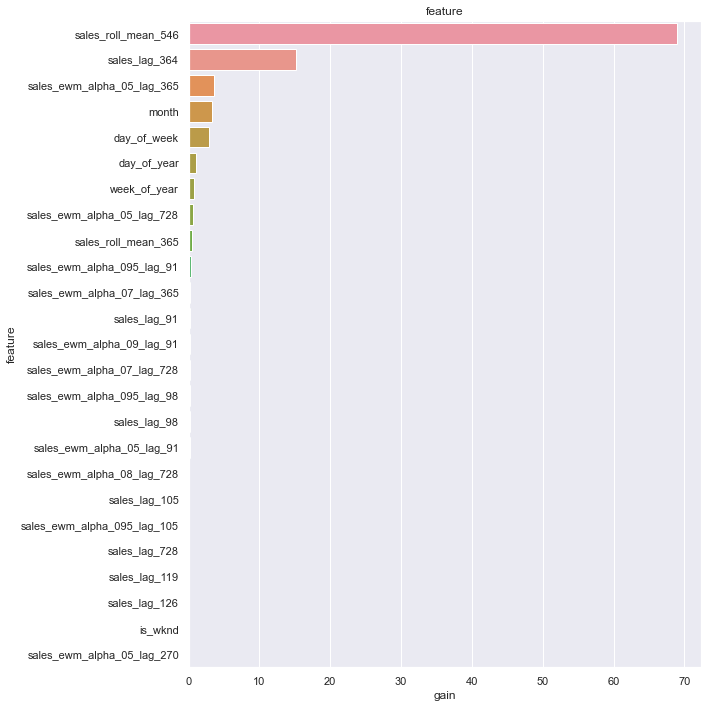

In [33]:

plot_importances(first_model, num=30, plot=True)

In [35]:
attributes=['sales','sales_roll_mean_546','sales_lag_364','sales_ewm_alpha_05_lag_365','month',
                    'day_of_week',
                    'day_of_year',
                   'week_of_year', 
    'sales_ewm_alpha_05_lag_728', 
    'sales_ewm_alpha_095_lag_91' ,
           'sales_roll_mean_365',  
    'sales_ewm_alpha_07_lag_365', 
                  'sales_lag_91', 
    'sales_ewm_alpha_07_lag_728', 
                  'sales_lag_98',
     'sales_ewm_alpha_09_lag_91',
                'sales_lag_105',
       'sales_ewm_alpha_095_lag_98',   
     'sales_ewm_alpha_05_lag_91',     
                 'sales_lag_182',     
                 'sales_lag_728',     
    'sales_ewm_alpha_05_lag_270',     
    'sales_ewm_alpha_05_lag_112',     
                 'sales_lag_119',     
    'sales_ewm_alpha_09_lag_728',      
     'sales_ewm_alpha_09_lag_98'] 

In [37]:
data=df[attributes]

In [38]:
data.head()

,sales,sales_roll_mean_546,sales_lag_364,sales_ewm_alpha_05_lag_365,month,day_of_week,day_of_year,week_of_year,sales_ewm_alpha_05_lag_728,sales_ewm_alpha_095_lag_91,sales_roll_mean_365,sales_ewm_alpha_07_lag_365,sales_lag_91,sales_ewm_alpha_07_lag_728,sales_lag_98,sales_ewm_alpha_09_lag_91,sales_lag_105,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_05_lag_91,sales_lag_182,sales_lag_728,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_112,sales_lag_119,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_09_lag_98
0,2.639057,48.0,50.0,50.0,1,2,1,1,48.0,52.0,49.0,50.0,52.0,48.0,52.0,52.0,52.0,52.0,52.0,51.0,48.0,50.0,51.0,51.0,48.0,52.0
1,2.484907,48.0,50.0,50.0,1,3,2,1,48.0,52.0,49.0,50.0,52.0,48.0,52.0,52.0,52.0,52.0,52.0,51.0,48.0,50.0,51.0,51.0,48.0,52.0
2,2.708050,48.0,50.0,50.0,1,4,3,1,48.0,52.0,49.0,50.0,52.0,48.0,52.0,52.0,52.0,52.0,52.0,51.0,48.0,50.0,51.0,51.0,48.0,52.0
3,2.639057,48.0,50.0,50.0,1,5,4,1,48.0,52.0,49.0,50.0,52.0,48.0,52.0,52.0,52.0,52.0,52.0,51.0,48.0,50.0,51.0,51.0,48.0,52.0
4,2.397895,48.0,50.0,50.0,1,6,5,1,48.0,52.0,49.0,50.0,52.0,48.0,52.0,52.0,52.0,52.0,52.0,51.0,48.0,50.0,51.0,51.0,48.0,52.0


In [39]:
data.isnull().sum()

sales                         0
sales_roll_mean_546           0
sales_lag_364                 0
sales_ewm_alpha_05_lag_365    0
month                         0
day_of_week                   0
day_of_year                   0
week_of_year                  0
sales_ewm_alpha_05_lag_728    0
sales_ewm_alpha_095_lag_91    0
sales_roll_mean_365           0
sales_ewm_alpha_07_lag_365    0
sales_lag_91                  0
sales_ewm_alpha_07_lag_728    0
sales_lag_98                  0
sales_ewm_alpha_09_lag_91     0
sales_lag_105                 0
sales_ewm_alpha_095_lag_98    0
sales_ewm_alpha_05_lag_91     0
sales_lag_182                 0
sales_lag_728                 0
sales_ewm_alpha_05_lag_270    0
sales_ewm_alpha_05_lag_112    0
sales_lag_119                 0
sales_ewm_alpha_09_lag_728    0
sales_ewm_alpha_09_lag_98     0
dtype: int64

In [34]:
data.shape

NameError: name 'data' is not defined

In [35]:
attributes1=['item', 'store', 'month', 'day_of_week', 'day_of_year', 'week_of_year', 'sales_roll_mean_546','sales_lag_364','sales_ewm_alpha_05_lag_365']

In [36]:
data1=df[attributes1]

KeyError: "['store', 'item'] not in index"

In [82]:
X=data1

In [83]:
X.tail()

,month,day_of_week,day_of_year,week_of_year,sales_roll_mean_546,sales_lag_364,sales_ewm_alpha_05_lag_365
912995,12,3,361,52,81.214899,43.005082,61.127792
912996,12,4,362,52,82.452033,68.838973,52.063896
912997,12,5,363,52,83.544659,64.134868,60.031948
912998,12,6,364,52,83.264508,64.873929,61.515974
912999,12,7,365,52,82.870559,69.861379,62.757987


In [84]:
y=df['sales']

In [85]:
y.head()

0    2.639057
1    2.484907
2    2.708050
3    2.639057
4    2.397895
Name: sales, dtype: float64

In [86]:
X.shape, y.shape

((913000, 7), (913000,))

In [87]:
from sklearn.model_selection import train_test_split

X_train, y_train, X_test, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

In [88]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()

In [89]:
X_train.shape, X_test.shape

((730400, 7), (730400,))

In [90]:
X_train_std= sc.fit_transform(X_train)

In [91]:
X_train_std

array([[ 0.42850935, -1.00163377,  0.46423645, ..., -0.40649921,
        -0.01856222, -0.01886534],
       [-1.60107413,  1.49920477, -1.72662392, ...,  1.30543103,
         0.15711319,  0.41651219],
       [ 1.58827134, -1.00163377,  1.46008207, ..., -0.98450099,
        -0.01856222, -0.01886534],
       ...,
       [-0.73125264,  1.49920477, -0.82562074, ..., -0.53858252,
        -0.65518959, -0.73373828],
       [ 1.00839034,  1.49920477,  0.95741714, ...,  2.09139247,
         2.33948094,  2.70448311],
       [ 1.58827134, -1.00163377,  1.56440876, ..., -0.2657336 ,
        -0.99188651, -0.69118574]])

In [92]:
X_test_std= sc.transform(X_test.values.reshape(-1,1))

ValueError: X has 1 features, but StandardScaler is expecting 7 features as input.

In [62]:
X_train

,month,day_of_week,day_of_year,week_of_year,sales_roll_mean_546,sales_lag_364,sales_ewm_alpha_05_lag_365
449427,8,2,232,34,38.944988,50.000000,50.000000
207799,1,7,1,52,79.669405,54.380409,60.327959
893250,12,2,337,49,25.195137,50.000000,50.000000
204633,5,4,122,18,49.875459,50.000000,50.000000
646797,1,3,29,5,50.201965,19.899341,29.488047
...,...,...,...,...,...,...,...
754024,9,6,252,36,44.796610,57.092138,45.926004
7942,10,3,274,40,12.282953,11.169480,14.419326
404006,4,7,96,14,35.802911,34.125906,33.041893
324215,10,7,284,41,98.366324,108.797031,114.602855


In [63]:
X_test

449427    3.761200
207799    4.158883
893250    2.833213
204633    4.189655
646797    3.610918
            ...   
754024    3.912023
7942      2.772589
404006    3.663562
324215    4.927254
295428    3.737670
Name: sales, Length: 730400, dtype: float64

In [58]:
X_test.astype(float)

449427    3.761200
207799    4.158883
893250    2.833213
204633    4.189655
646797    3.610918
            ...   
754024    3.912023
7942      2.772589
404006    3.663562
324215    4.927254
295428    3.737670
Name: sales, Length: 730400, dtype: float64

In [ ]:
import joblib
joblib.dump(first_model,r'C:\Users\Epoch\OneDrive\Desktop\salesprediction_deployement\models\lgbm.sav')